In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2
import tqdm

2024-07-14 19:49:56.836561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 19:50:06.816224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#importing data
classes_train = pd.read_csv('../data/train/_classes.csv')
classes_test = pd.read_csv('../data/test/_classes.csv')
classes_valid = pd.read_csv('../data/valid/_classes.csv')

pics_train = []
pics_valid = []
pics_test = []


for filename in classes_train['filename']:
    img = cv2.imread('../data/train/'+filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pics_train.append(img)

for filename in classes_valid['filename']:
    img = cv2.imread('../data/valid/'+filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pics_valid.append(img)

for filename in classes_test['filename']:
    img = cv2.imread('../data/test/'+filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pics_test.append(img)


In [3]:
pics_train = np.array(pics_train)
pics_valid = np.array(pics_valid)
pics_test = np.array(pics_test)

In [4]:
def crop_face(image):
    """
    Crops the face from input image using Haar Cascade Classifier

    Args:
        image: image

    Returns:
        face: face image
    """
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, 1.1, 4)
    if len(faces) == 0:
        return image
    for (x, y, w, h) in faces:
        if y-30 >= 0 or x-30 >= 0 or y+h+30 < image.shape[0] or x+w+30 < image.shape[1]:
            face = cv2.resize(image[y-30:y+30+h, x-30:x+w+30], (160, 160))
        else:
            face = cv2.resize(image[y:y+h, x:x+w], (160, 160))
    return face


# faces = []
# for image in tqdm.tqdm(pics_train[:100]):
#     face = crop_face(image)
#     if face is not None:
#         faces.append(face)

# plt.imshow(pics_train[0])

# test = crop_face(pics_train[0])

# plt.imshow(test, cmap='gray')

In [5]:
def hard_crop(image):
    return image[:,:,100:image.shape[2]-100]

In [6]:
train_cropped = hard_crop(pics_train)
valid_cropped = hard_crop(pics_valid)
test_cropped = hard_crop(pics_test)

In [18]:
train_img = []
valid_img = []
test_img = []

for pic in tqdm.tqdm(range(len(train_cropped))):
    img = cv2.resize(train_cropped[pic], (192, 160))
    train_img.append(img)

for pic in tqdm.tqdm(range(len(valid_cropped))):
    img = cv2.resize(valid_cropped[pic], (192, 160))
    valid_img.append(img)

for pic in tqdm.tqdm(range(len(test_cropped))):
    img = cv2.resize(test_cropped[pic], (192, 160))
    test_img.append(img)

train_img = np.array(train_img)
valid_img = np.array(valid_img)
test_img = np.array(test_img)

100%|██████████| 985/985 [00:00<00:00, 13742.48it/s]


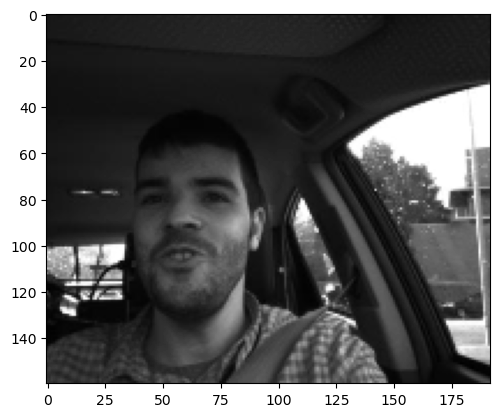

In [8]:
plt.imshow(test_img[34], cmap='gray')

In [19]:
import json
import os

train_img = train_img.tolist()
valid_img = valid_img.tolist()
test_img = test_img.tolist()

json_train = os.path.join('../data', 'train.json')
json_valid = os.path.join('../data', 'valid.json')
json_test =  os.path.join('../data', 'test.json')

# file_path = os.path.join('data', 'array.json')

with open(json_train, 'w') as f:
    json.dump(train_img, f)

with open(json_valid, 'w') as f:
    json.dump(valid_img, f)

with open(json_test, 'w') as f:
    json.dump(test_img, f)